In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from numpy import array
from scipy.optimize import curve_fit

# Change Data Access Location For Google Drive



In [ ]:
os.chdir('/content/drive/My Drive/New LSTM Crack')

# Define Inputs

In [ ]:
# Use the datapoint every (interval) point
interval = 1000
# How Many datapoints around the selected to use
# For 0, Just uses the data in front
# For others, Uses (avg) in front and behind
avg = 50
# Desired Temperature to generate data for
desired_temp= 573
# Desired Force to generate data for
force = 1600

# Read in data files that the 2-D polynomial will be fit to

In [ ]:
T1 = './Test/HeatTreated/t35_4-3-21_R05_1600N_testing.csv'
T1_df = pd.read_csv(T1)
T1_arr = np.asarray(T1_df)

T2 = './Test/HeatTreated/t150_4-15-21_R05_1600N_testing.csv'
T2_df = pd.read_csv(T2)
T2_arr = np.asarray(T2_df)

T3 = './Test/HeatTreated/t250_4-8-21_R05_1600N_testing.csv'
T3_df = pd.read_csv(T3)
T3_arr = np.asarray(T3_df)

#Adjust the Size of the arrays to take into consideration the need for same
#length vector operations 
min_size = min(len(T1_arr),len(T2_arr),len(T3_arr))
T1_cl = T1_arr[:min_size,1]
T2_cl = T2_arr[:min_size,1]
T3_cl = T3_arr[:min_size,1]

# Fit Data to 2-D polynomial

Create's Temperature inputs for given number of points

In [ ]:
i = 0

X = []

while i <= len(T1_cl):
  # Temperatures to use are defined below, Should Correspond to
  # Data in use
  X_timestep = [[308.15],[433.15],[523.15]]
  X.append(X_timestep)
  i += interval

# Array of temperatures
# Takes form
# [[T1]
#  [T2]
#  [T3]]
x = np.asarray(X)

Create's Time inputs for given number of points

In [ ]:
i = 0

Y = []

while i <= len(T1_cl):
  # Timestep defined based on loop
  Y_timestep = [[i],[i],[i]]
  Y.append(Y_timestep)
  i += interval

#Array of timesteps
# Takes form
# [[Timestep]
#  [Timestep]
#  [Timestep]]
y = np.asarray(Y)

Create the Vector of Crack Lengths to fit the curve to

In [ ]:
i = 0

z = []

while i <= len(T1_cl):
  # Special Case of first point: No data behind
  if i == 0:
    #Take average of only the (avg) amount of datapoints in front
    z_timestep = [[np.average(T1_cl[i:i+avg])], [np.average(T2_cl[i:i+avg])], [np.average(T3_cl[i:i+avg])]]
    z.append(z_timestep)
    i+= interval
  else:
    #Take average of only the (avg) amount of datapoints in front and (avg) amount behind
    z_timestep = [[np.average(T1_cl[i-avg:i+avg])], [np.average(T2_cl[i-avg:i+avg])], [np.average(T3_cl[i-avg:i+avg])]]
    z.append(z_timestep)
    i+= interval

#Array of timesteps
# Takes form
#[[[CL @ T1 @ Timestep]
#  [CL @ T2 @ Timestep]
#  [CL @ T3 @ Timestep]]
Z = np.asarray(z)

Generate coefficients for the polynomials

In [ ]:
coeff_mtx = []
X = x.flatten()
Y = y.flatten()

# 2D polynomial X,Y values for previous Timesteps and Temperatures
A = np.array([X*0+1, X, Y, X**2, X**2*Y, X**2*Y**2, Y**2, X*Y**2, X*Y]).T
# Target Values
B = Z.flatten()
# Fit Curve
coeff, r, rank, s = np.linalg.lstsq(A, B)
# Generate Coeff matrix and save for later
coeff_mtx.append(coeff)
coeff_mtx = np.asarray(coeff_mtx)

# Generate New Data

Generate time and temperature Vectors

In [ ]:
# Generate data for number of points equal to the smallest amount of data read in
times = np.arange(0, min_size, 1)
# Temperature is (desired_temp)
temp = np.asarray([desired_temp])

Generate the New Data using 2-D polynomial and coefficients

In [ ]:
vals = []

# Access Coefficient Matrix
for i in coeff_mtx:
  # Access desired Temperature
  for j in temp:
    # Access number of datapoints to create
    for k in times:
      # From before the X value is Temperature
      coeff_x = j
      # From before the Y value is time
      coeff_y = k
      # Use Coefficients and X and Y values to calculate the Crack Length at a time and temperature
      val = i[0] + coeff_x*i[1] + coeff_y*i[2] + coeff_x**2*i[3] + coeff_x**2*coeff_y*i[4] + coeff_x**2*coeff_y**2*i[5] + coeff_y**2*i[6] + coeff_x*coeff_y**2*i[7] + coeff_x*coeff_y*i[8]
      vals.append([coeff_x, coeff_y, val])

vals = np.asarray(vals).reshape(len(temp), len(times),3)

Generate Noise to Imitate Real Noise In Dataset

In [ ]:
# Generate Noise based around 0 with deviation of .010 in shape of Crack Length Information
noise = np.random.normal(0,.010, vals[:,:,2].shape)
# Add in Noise
vals[:,:,2] = vals[:,:,2] + noise

In [ ]:
#For Temp
vals = vals.reshape(min_size,3)

Plot Crack Length Data For Preview

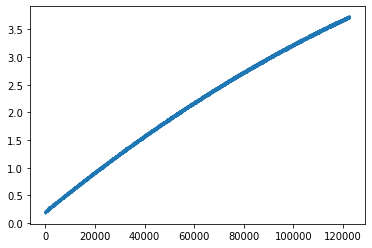

In [ ]:
plt.plot(vals[:,2])

Create Force Vector for Desired Force

In [ ]:
force_arr = np.full((min_size,1),force)

Properly Format DataFrame and Save

In [ ]:
# This is all just formatting to get everything in the form I use
dataframe = pd.DataFrame(vals)
dataframe.insert(3,'Force',force_arr)
dataframe.rename(columns={0:'Temp'}, inplace=True)
dataframe.rename(columns={1:'Timestep'}, inplace=True)
dataframe.rename(columns={2:'Crack Length'}, inplace=True)
dataframe = dataframe[['Timestep', 'Crack Length', 'Force','Temp']]
#save
dataframe.to_csv('./Test/HeatTreated/{}N_HT_{}K.csv'.format(force,desired_temp), index=False)